In [1]:
import pandas as pd
import bt
import time
import os
import h5py

In [14]:
tickers = 'aapl,msft,c,gs,ge'
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(
    tickers_new,
    start='2010-01-01',
    end = '2022-07-01'
)
data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn
Date,,,,,,,,,,,,,,
2010-01-04,6.478999,23.474918,26.893297,136.536926,67.992668,42.974468,40.413692,18.498014,6.695000,29.669836,37.090000,23.853481,27.843178,18.196350
2010-01-05,6.490200,23.482500,27.921581,138.950943,68.344711,42.476147,40.426907,18.274242,6.734500,30.244541,37.700001,23.782904,27.773716,18.091408
2010-01-06,6.386965,23.338398,28.791649,137.467804,67.992668,42.821636,40.235157,18.267767,6.612500,30.410736,37.619999,23.748518,27.626129,17.958488
2010-01-07,6.375157,23.095676,28.870752,140.157883,71.513283,42.516010,40.016964,18.222364,6.500000,31.013132,36.889999,23.593327,27.634809,18.014450
2010-01-08,6.417541,23.254967,28.396152,137.507278,73.053581,42.662193,39.964062,17.885090,6.676000,30.936951,36.689999,23.601694,27.678217,18.427208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,140.444229,264.041077,44.782074,289.352966,52.030643,174.613464,138.882568,60.242382,116.459999,111.237900,387.720001,326.949371,97.462357,149.027649
2022-06-27,140.444229,261.269501,44.754005,287.470184,51.805439,174.450607,137.824219,60.118153,113.220001,110.346626,381.070007,325.297302,96.296165,148.712280
2022-06-28,136.260391,252.974411,44.173874,286.237274,51.160873,169.488739,135.582474,59.516106,107.400002,109.815666,365.630005,314.870514,95.608398,147.317078


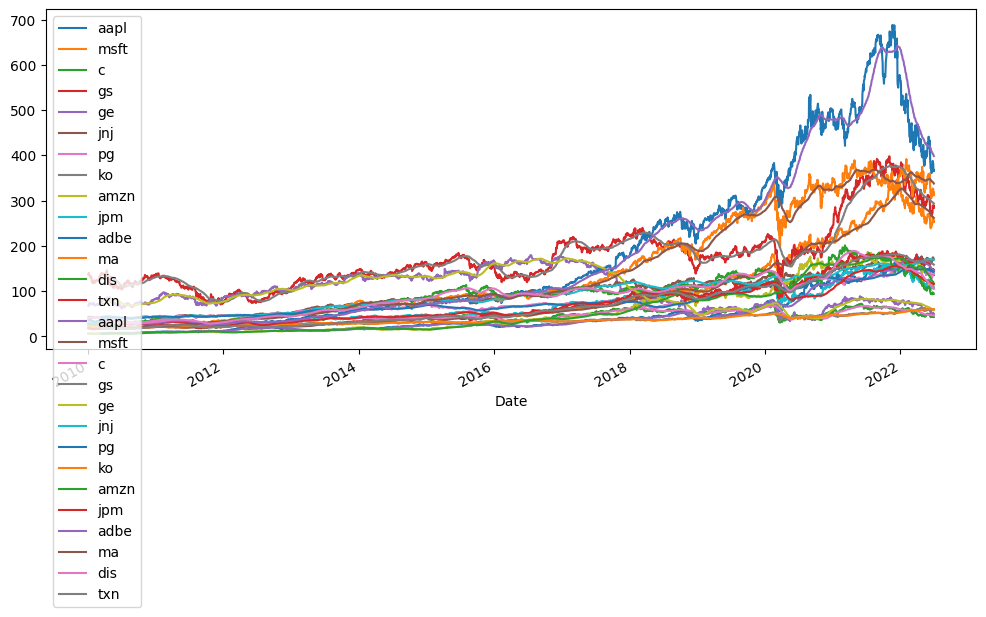

In [15]:
sma = data.rolling(50).mean()

plot = bt.merge(data, sma).plot(figsize=(12, 5))

In [20]:
st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 


Run time: 1.53 seconds


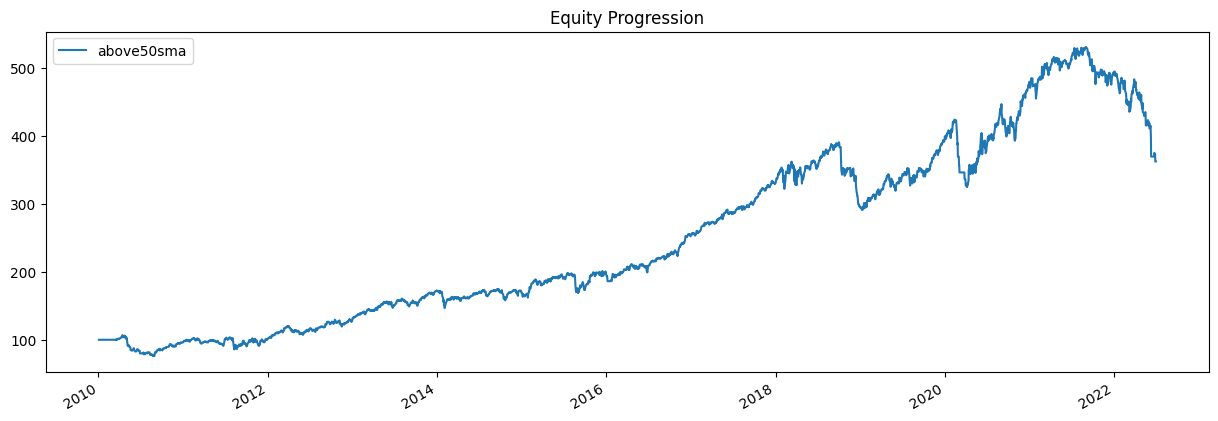

In [18]:
# what does the equity curve look like?
res.plot();

In [19]:
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2022-06-30
Risk-free rate       0.00%

Total Return         262.07%
Daily Sharpe         0.70
Daily Sortino        1.06
CAGR                 10.85%
Max Drawdown         -31.75%
Calmar Ratio         0.34

MTD                  -13.76%
3m                   -24.47%
6m                   -26.27%
YTD                  -26.12%
1Y                   -29.33%
3Y (ann.)            2.06%
5Y (ann.)            4.92%
10Y (ann.)           12.00%
Since Incep. (ann.)  10.85%

Daily Sharpe         0.70
Daily Sortino        1.06
Daily Mean (ann.)    11.73%
Daily Vol (ann.)     16.78%
Daily Skew           -0.71
Daily Kurt           5.40
Best Day             5.27%
Worst Day            -8.03%

Monthly Sharpe       0.69
Monthly Sortino      1.09
Monthly Mean (ann.)  11.91%
Monthly Vol (ann.)   17.16%
Monthly Skew         -0.89
Monthly Kurt         1.75
Best Month           12.97%
Worst Month    

In [17]:
# convert index to epoch time
data_atlas = data.copy()
data_atlas.index = data_atlas.index.astype('int64')

# split columns into indivual dataframes
dfs = {col: pd.DataFrame(data_atlas[col]) for col in data_atlas}

output_path = os.path.join(os.getcwd(), 'data_sp500.h5')
if os.path.exists(output_path):
    os.remove(output_path)


with h5py.File(output_path, "a") as file:
    for ticker, df in dfs.items():
        #rename ticker column to "close"
        df.columns = ["close"]
        df["50_ma"] = sma[ticker].values
        df.dropna(inplace = True)
        stock_data = df.to_numpy()
        index = df.index.map(lambda timestamp: int(timestamp)).to_numpy()
        print(ticker, len(index))

        dataset = file.create_dataset(f"{ticker}/data", data=stock_data)
        file.create_dataset(
                f"{ticker}/datetime",
                data = index,
        )
        for column in df.columns:
            dataset.attrs[column] = column

aapl 3096
msft 3096
c 3096
gs 3096
ge 3096
jnj 3096
pg 3096
ko 3096
amzn 3096
jpm 3096
adbe 3096
ma 3096
dis 3096
txn 3096


In [57]:
# create a function that returns a random walk of prices
import numpy as np

# set numpy random seed
np.random.seed(0)

def generate_arithmetic_random_walk(n, mean_step, std_dev, s0):
    """
    Generate an arithmetic random walk.

    Parameters:
    - n: Number of steps in the random walk.
    - mean_step: Mean of the step size.
    - std_dev: Standard deviation of the step size.

    Returns:
    - A NumPy array representing the arithmetic random walk.
    """
    # Generate random steps
    steps = np.random.normal(loc=mean_step, scale=std_dev, size=n)

    # Calculate cumulative sum to get the random walk
    random_walk = np.cumsum(steps)

    random_walk += s0

    return random_walk

# Example usage
num_stocks = 500
num_steps = 5000
mean_step_size = 0.05
s0 = 100.0
std_deviation = 0.2

data_large = pd.DataFrame(
    {
        f"stock_{i}": generate_arithmetic_random_walk(
            num_steps, mean_step_size, std_deviation, s0
        )
        for i in range(num_stocks)
    }
)

# set the datetime index to be a range of dates starting from 1/1/2010
data_large.index = pd.date_range("1/1/2010", periods=num_steps, freq="S")


In [58]:
data_large.index = pd.date_range("1/1/2010", periods=num_steps, freq="S")
data_large

,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,...,stock_490,stock_491,stock_492,stock_493,stock_494,stock_495,stock_496,stock_497,stock_498,stock_499
2010-01-01 00:00:00,100.352810,100.061945,99.959577,100.493996,100.066009,100.060424,100.074246,100.077446,99.612100,100.112343,...,99.966382,100.359915,100.163106,99.728248,100.200849,100.129416,100.010277,100.030765,99.876198,99.888045
2010-01-01 00:00:01,100.432842,99.914454,99.792930,100.611400,100.065913,100.089774,100.135203,100.355902,99.759870,99.846807,...,99.859374,100.540129,100.306502,99.766274,100.369963,100.109420,100.287051,100.062195,100.088373,99.635277
2010-01-01 00:00:02,100.628590,99.607070,100.139650,100.531929,100.229536,100.211804,100.236028,100.185350,100.038807,99.855797,...,99.485078,100.487051,100.207148,99.774131,99.952676,99.922047,100.058082,100.091415,100.225516,99.578622
2010-01-01 00:00:03,101.076768,99.494619,100.177780,100.618639,100.315179,100.522238,100.263088,100.145507,99.876090,100.211100,...,99.416840,100.401712,100.223161,99.527920,99.838934,99.836394,99.881553,99.870578,100.318756,99.551016
2010-01-01 00:00:04,101.450280,99.174716,100.142218,100.718699,99.814390,100.524676,100.393840,100.080360,99.712326,100.283543,...,99.315114,100.446556,100.022524,99.476802,100.176391,99.737748,99.783316,99.752270,100.206832,99.542377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01 01:23:15,84.810019,77.493722,105.051902,116.871941,104.245177,84.628621,91.838440,103.694072,114.641247,78.203079,...,104.802425,91.614118,90.974555,73.577492,88.177946,106.457485,73.496863,76.770932,104.104304,65.599216
2010-01-01 01:23:16,84.959352,77.502194,105.419678,116.850141,104.395343,84.511531,91.642249,104.096295,114.549587,77.858964,...,105.078739,91.816844,90.917437,73.776624,88.318538,106.389754,73.301556,76.684284,104.378482,65.589293
2010-01-01 01:23:17,85.145188,77.605569,105.570297,116.838689,104.283215,84.209275,91.432547,104.434266,114.746052,77.808896,...,104.985109,91.718262,91.065889,74.191564,88.275820,106.701504,73.242197,76.758055,104.112212,66.083012
2010-01-01 01:23:18,85.191072,77.598984,105.454090,116.626903,103.931161,84.404644,91.458525,104.474260,114.756555,77.925841,...,105.167537,91.679660,91.440085,74.350781,88.342393,106.602302,73.399965,76.685953,104.011859,66.151957


In [59]:

st = time.time()
sma = data_large.rolling(50).mean()
signal = data_large > sma

# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data_large > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data_large)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 

Run time: 39.46 seconds


In [62]:
res.display()

Stat                 above50sma
-------------------  ------------
Start                2009-12-31
End                  2010-01-01
Risk-free rate       0.00%

Total Return         -0.04%
Daily Sharpe         -
Daily Sortino        -
CAGR                 -12.42%
Max Drawdown         -0.04%
Calmar Ratio         -342.13

MTD                  -0.04%
3m                   -
6m                   -
YTD                  -0.04%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -12.42%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -9.15%
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -0.04%
Worst Day            -0.04%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  -
Monthly Vol (ann.)   -
Monthly Skew         -
Monthly Kurt         -
Best Month           -
Worst Month          -

Yearly Sharpe        -
Yearly Sortino       -
Yearly Mean          -
Yea

In [60]:
(39.46 * 1000) / 71

555.7746478873239

In [61]:
data_large.index = data_large.index.astype('int64')

output_path = os.path.join(os.getcwd(), 'data_large.h5')
STORE = True
if STORE:
    if os.path.exists(output_path):
        os.remove(output_path)
    with h5py.File(output_path, "a") as file:
        for col in data_large.columns:
            #rename ticker column to "close"
            df = pd.DataFrame(data_large[col])
            df.columns = ["close"]
            df["50_ma"] = df["close"].rolling(50).mean()
            df.dropna(inplace = True)
            stock_data = df.to_numpy()
            index = df.index.map(lambda timestamp: int(timestamp)).to_numpy()
            print(ticker, len(index))

            dataset = file.create_dataset(f"{col}/data", data=stock_data)
            file.create_dataset(
                    f"{col}/datetime",
                    data = index,
            )
            for column in df.columns:
                dataset.attrs[column] = column

aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
aapl 4951
